![logo_ironhack_blue 7](https://user-images.githubusercontent.com/23629340/40541063-a07a0a8a-601a-11e8-91b5-2f13e4e6b441.png)

# Lab | Random Forests

For this lab, you will be using the CSV files provided in the `files_for_lab` folder.

## Instructions

- Apply the Random Forests algorithm but this time only by upscaling the data.
- Discuss the output and its impact in the bussiness scenario. Is the cost of a false positive equals to the cost of the false negative? How would you change your algorithm or data in order to maximize the return of the bussiness?

## Imports

In [116]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
from sklearn.metrics import make_scorer, recall_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
cat = pd.read_csv("files_for_lab/categorical.csv")
num = pd.read_csv("files_for_lab/numerical.csv")
target = pd.read_csv("files_for_lab/target.csv")

## Categorical cleaning

In [5]:
cat.head()

,STATE,CLUSTER,HOMEOWNR,GENDER,DATASRCE,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B,...,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM
0,IL,36,H,F,3,L,E,C,T,2,...,37,12,92,8,94,2,95,12,89,11
1,CA,14,H,M,3,L,G,A,S,1,...,52,2,93,10,95,12,95,12,93,10
2,NC,43,U,M,3,L,E,C,R,2,...,0,2,91,11,92,7,95,12,90,1
3,CA,44,U,F,3,L,E,C,R,2,...,28,1,87,11,94,11,95,12,87,2
4,FL,16,H,F,3,L,F,A,S,2,...,20,1,93,10,96,1,96,1,79,3


In [19]:
cat.isna().sum()

STATE           0
CLUSTER         0
HOMEOWNR        0
GENDER          0
DATASRCE        0
RFA_2R          0
RFA_2A          0
GEOCODE2        0
DOMAIN_A        0
DOMAIN_B        0
ODATEW_YR       0
ODATEW_MM       0
DOB_YR          0
DOB_MM          0
MINRDATE_YR     0
MINRDATE_MM     0
MAXRDATE_YR     0
MAXRDATE_MM     0
LASTDATE_YR     0
LASTDATE_MM     0
FIRSTDATE_YR    0
FIRSTDATE_MM    0
dtype: int64

We are going to divide categoricals in two subgroups, one with numbers and another with objects

In [26]:
cat_num = cat.select_dtypes(np.number)
cat_cat = cat.select_dtypes(object)

In [16]:
cat_num.head()

,CLUSTER,DATASRCE,DOMAIN_B,ODATEW_YR,ODATEW_MM,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM
0,36,3,2,89,1,37,12,92,8,94,2,95,12,89,11
1,14,3,1,94,1,52,2,93,10,95,12,95,12,93,10
2,43,3,2,90,1,0,2,91,11,92,7,95,12,90,1
3,44,3,2,87,1,28,1,87,11,94,11,95,12,87,2
4,16,3,2,86,1,20,1,93,10,96,1,96,1,79,3


In [23]:
cat_num.nunique()

CLUSTER         53
DATASRCE         3
DOMAIN_B         4
ODATEW_YR       15
ODATEW_MM       12
DOB_YR          96
DOB_MM          12
MINRDATE_YR     20
MINRDATE_MM     12
MAXRDATE_YR     18
MAXRDATE_MM     12
LASTDATE_YR      3
LASTDATE_MM     12
FIRSTDATE_YR    26
FIRSTDATE_MM    12
dtype: int64

In [15]:
cat_cat.head()

,STATE,HOMEOWNR,GENDER,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A
0,IL,H,F,L,E,C,T
1,CA,H,M,L,G,A,S
2,NC,U,M,L,E,C,R
3,CA,U,F,L,E,C,R
4,FL,H,F,L,F,A,S


In [17]:
cat_cat.nunique()

STATE       12
HOMEOWNR     2
GENDER       3
RFA_2R       1
RFA_2A       4
GEOCODE2     4
DOMAIN_A     5
dtype: int64

Dummifying the categorical objects

In [27]:
cat_cat_dum = pd.get_dummies(cat_cat, drop_first = True)
cat_cat_dum.head()

,STATE_FL,STATE_GA,STATE_IL,STATE_IN,STATE_MI,STATE_MO,STATE_NC,STATE_TX,STATE_WA,STATE_WI,...,RFA_2A_E,RFA_2A_F,RFA_2A_G,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D,DOMAIN_A_R,DOMAIN_A_S,DOMAIN_A_T,DOMAIN_A_U
0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


## Numerical Cleaning

In [6]:
num.head()

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,...,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2
0,0,60.000000,5,9,0,0,39,34,18,10,...,14,5.0,12.0,10.0,4,7.741935,95515,0,4,39
1,1,46.000000,6,9,16,0,15,55,11,6,...,1,10.0,25.0,25.0,18,15.666667,148535,0,2,1
2,1,61.611649,3,1,2,0,20,29,33,6,...,14,2.0,16.0,5.0,12,7.481481,15078,1,4,60
3,0,70.000000,1,4,2,0,23,14,31,3,...,7,2.0,11.0,10.0,9,6.812500,172556,1,4,41
4,0,78.000000,3,2,60,1,28,9,53,26,...,8,3.0,15.0,15.0,14,6.864865,7112,1,2,26


In [20]:
num.isna().sum()

TCODE       0
AGE         0
INCOME      0
WEALTH1     0
HIT         0
           ..
AVGGIFT     0
CONTROLN    0
HPHONE_D    0
RFA_2F      0
CLUSTER2    0
Length: 315, dtype: int64

In [7]:
target.head()

,TARGET_B,TARGET_D
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0


## Feature Selection

### Variance Threshold

We are also going to include the categorical numbers to reduce the number of columns

In [35]:
num_concat = pd.concat([num, cat_num], axis = 1)
num_concat.head()

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,...,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM
0,0,60.000000,5,9,0,0,39,34,18,10,...,37,12,92,8,94,2,95,12,89,11
1,1,46.000000,6,9,16,0,15,55,11,6,...,52,2,93,10,95,12,95,12,93,10
2,1,61.611649,3,1,2,0,20,29,33,6,...,0,2,91,11,92,7,95,12,90,1
3,0,70.000000,1,4,2,0,23,14,31,3,...,28,1,87,11,94,11,95,12,87,2
4,0,78.000000,3,2,60,1,28,9,53,26,...,20,1,93,10,96,1,96,1,79,3


In [36]:
scaler = MinMaxScaler()
num_mm = scaler.fit_transform(num_concat)
num_mm = pd.DataFrame(num_mm, columns = num_concat.columns)
num_mm.head()

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,...,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM
0,0.000000,0.608247,0.666667,1.000000,0.000000,0.000000,0.393939,0.343434,0.181818,0.101010,...,0.381443,1.000000,0.772727,0.636364,0.863636,0.090909,0.0,1.0,0.927083,0.909091
1,0.000014,0.463918,0.833333,1.000000,0.066390,0.000000,0.151515,0.555556,0.111111,0.060606,...,0.536082,0.090909,0.818182,0.818182,0.909091,1.000000,0.0,1.0,0.968750,0.818182
2,0.000014,0.624862,0.333333,0.111111,0.008299,0.000000,0.202020,0.292929,0.333333,0.060606,...,0.000000,0.090909,0.727273,0.909091,0.772727,0.545455,0.0,1.0,0.937500,0.000000
3,0.000000,0.711340,0.000000,0.444444,0.008299,0.000000,0.232323,0.141414,0.313131,0.030303,...,0.288660,0.000000,0.545455,0.909091,0.863636,0.909091,0.0,1.0,0.906250,0.090909
4,0.000000,0.793814,0.333333,0.222222,0.248963,0.010101,0.282828,0.090909,0.535354,0.262626,...,0.206186,0.000000,0.818182,0.818182,0.954545,0.000000,0.5,0.0,0.822917,0.181818


In [37]:
var_threshold = 0.02
sel = VarianceThreshold(threshold=var_threshold)
num_mm_vt = sel.fit_transform(num_mm)
num_mm_vt = pd.DataFrame(num_mm_vt, columns = sel.get_feature_names_out())
num_mm_vt.head()

,AGE,INCOME,WEALTH1,VIETVETS,WWIIVETS,WEALTH2,POP90C1,POP90C2,POP90C3,ETH1,...,DATASRCE,DOMAIN_B,ODATEW_YR,DOB_YR,DOB_MM,MINRDATE_MM,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_MM
0,0.608247,0.666667,1.000000,0.343434,0.181818,0.555556,0.0,0.353535,0.656566,0.929293,...,1.0,0.333333,0.428571,0.381443,1.000000,0.636364,0.090909,0.0,1.0,0.909091
1,0.463918,0.833333,1.000000,0.555556,0.111111,1.000000,1.0,0.000000,0.000000,0.676768,...,1.0,0.000000,0.785714,0.536082,0.090909,0.818182,1.000000,0.0,1.0,0.818182
2,0.624862,0.333333,0.111111,0.292929,0.333333,0.111111,0.0,0.020202,0.989899,0.969697,...,1.0,0.333333,0.500000,0.000000,0.090909,0.909091,0.545455,0.0,1.0,0.000000
3,0.711340,0.000000,0.444444,0.141414,0.313131,0.000000,0.0,0.080808,0.929293,0.616162,...,1.0,0.333333,0.285714,0.288660,0.000000,0.909091,0.909091,0.0,1.0,0.090909
4,0.793814,0.333333,0.222222,0.090909,0.535354,1.000000,1.0,0.000000,0.000000,0.020202,...,1.0,0.333333,0.214286,0.206186,0.000000,0.818182,0.000000,0.5,0.0,0.181818


### K-Best

#### Upsampling

In [100]:
data = pd.concat([num_mm_vt, cat_cat_dum, target["TARGET_B"]], axis = 1)
data.shape

(95412, 115)

In [99]:
X_no = data[data["TARGET_B"] == 0]
X_yes = data[data["TARGET_B"] == 1].sample(len(X_no), replace = True)
X_yes.shape, X_no.shape

((90569, 115), (90569, 115))

In [109]:
X = pd.concat([X_yes, X_no]).sort_index().drop(columns = "TARGET_B")
X = X.reset_index(drop=True)
X.head()

,AGE,INCOME,WEALTH1,VIETVETS,WWIIVETS,WEALTH2,POP90C1,POP90C2,POP90C3,ETH1,...,RFA_2A_E,RFA_2A_F,RFA_2A_G,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D,DOMAIN_A_R,DOMAIN_A_S,DOMAIN_A_T,DOMAIN_A_U
0,0.608247,0.666667,1.000000,0.343434,0.181818,0.555556,0.0,0.353535,0.656566,0.929293,...,1,0,0,0,1,0,0,0,1,0
1,0.463918,0.833333,1.000000,0.555556,0.111111,1.000000,1.0,0.000000,0.000000,0.676768,...,0,0,1,0,0,0,0,1,0,0
2,0.624862,0.333333,0.111111,0.292929,0.333333,0.111111,0.0,0.020202,0.989899,0.969697,...,1,0,0,0,1,0,1,0,0,0
3,0.711340,0.000000,0.444444,0.141414,0.313131,0.000000,0.0,0.080808,0.929293,0.616162,...,1,0,0,0,1,0,1,0,0,0
4,0.793814,0.333333,0.222222,0.090909,0.535354,1.000000,1.0,0.000000,0.000000,0.020202,...,0,1,0,0,0,0,0,1,0,0


In [108]:
y = target["TARGET_B"][X_yes.index.union(X_no.index)]
y = y.reset_index(drop=True)
y.head()

0    0
1    0
2    0
3    0
4    0
Name: TARGET_B, dtype: int64

In [111]:
kbest = SelectKBest(f_classif, k=7)
kbest.fit(X,y)
X_new = kbest.transform(X)
X_new = pd.DataFrame(X_new, columns = kbest.get_feature_names_out())
X_new.head()

,CARDPROM,RFA_2F,ODATEW_YR,LASTDATE_YR,RFA_2A_E,RFA_2A_F,RFA_2A_G
0,0.433333,1.000000,0.428571,0.0,1.0,0.0,0.0
1,0.183333,0.333333,0.785714,0.0,0.0,0.0,1.0
2,0.416667,1.000000,0.500000,0.0,1.0,0.0,0.0
3,0.433333,1.000000,0.285714,0.0,1.0,0.0,0.0
4,0.700000,0.333333,0.214286,0.5,0.0,1.0,0.0


In [115]:
ml = [elem for elem in zip(kbest.scores_, X.columns.tolist())]
ml.sort(reverse=True)
df = pd.DataFrame(data = ml, columns = ['Score','Column'])
df.head(10)

,Score,Column
0,4616.553019,RFA_2F
1,1351.332423,LASTDATE_YR
2,1334.917799,RFA_2A_G
3,1071.593413,RFA_2A_E
4,984.160358,CARDPROM
5,979.711520,ODATEW_YR
6,915.056506,RFA_2A_F
7,563.667593,HVP4
8,553.785032,HV2
9,540.847297,HVP3


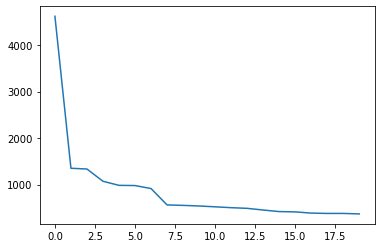

In [114]:
plt.plot(df["Score"][:20])

We will pick the first 7 as there is a huge drop in score after that

## Train/Test split

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.22, random_state = 22)

## Grid Search

### Scorer (Recall)

In [134]:
# We use the recall function because a False Negative costs more money (donation missed) than a False positive (letter cost)

scorer = make_scorer(recall_score)

### Grid

In [166]:
max_depth_choices = [2,3,4,5]
min_samples_split_choices = [2,3,4,5,6,7,8,9,10]
criterion_choices = ["gini", "entropy"]

grid = {'max_depth': max_depth_choices,
        'min_samples_split': min_samples_split_choices,
        "criterion" : criterion_choices}

In [169]:
len(max_depth_choices)*len(min_samples_split_choices)*len(criterion_choices)*5

360

### Search

In [170]:
rfc = RandomForestClassifier()

In [171]:
grid_search = GridSearchCV(estimator = rfc, scoring = scorer, param_grid = grid, cv = 5, verbose = 2)

In [172]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END ...criterion=gini, max_depth=2, min_samples_split=2; total time=   2.1s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=2; total time=   2.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=2; total time=   2.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=2; total time=   2.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=2; total time=   2.1s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=3; total time=   2.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=3; total time=   2.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=3; total time=   2.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=3; total time=   2.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=3; total time=   2.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=4; total time=   2.0s
[CV] END ...criterion=gini, max_depth=2, min_sa

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring=make_scorer(recall_score), verbose=2)

### Results

In [173]:
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 10}

In [174]:
grid_search.best_score_

0.5614871035695531

## Conclusion

In this particular case, a False Positive means that the company will spend money in sending a letter to someone that won't donate anything, meanwhile a False Negative means that a donation will me missed as a letter asking for it won't me sent.

For now, it seems that a False Negative is worse for the company, but this can change if the number of False Positives is big enough, or if the value of the lost donations is small.